# Importing necessary libraries

In [48]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [49]:
# Watermark code to print library versions
def print_versions():
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
    print(f"numpy version: {np.__version__}")
    print(f"pandas version: {pd.__version__}")
    print(f"matplotlib version: {matplotlib.__version__}")
    try:
        import einops
        print(f"einops version: {einops.__version__}")
    except ImportError:
        print("einops is not installed")

print_versions()

torch version: 2.4.0
torchvision version: 0.19.0
numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.7.5
einops version: 0.8.0


# Loading and cropping the image

In [50]:
import requests

if os.path.exists('assets\toucan.jpeg'):
    print('toucan.jpeg exists')
else:
    url = 'https://images.unsplash.com/photo-1550853024-fae8cd4be47f?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MTB8fGJpcmR8ZW58MHx8MHx8fDA%3D'
    output_file = 'toucan.jpg'
    
    try:
        response = requests.get(url)
        response.raise_for_status()  
        
        with open(output_file, 'wb') as file:
            file.write(response.content)
        
        print("Download successful")
    except requests.RequestException as e:
        print(f"An error occurred: {e}")


toucan.jpg exists


In [51]:
# Read in a image from torchvision
img = torchvision.io.read_image("toucan.jpg")
print(img.shape)

torch.Size([3, 2961, 3000])


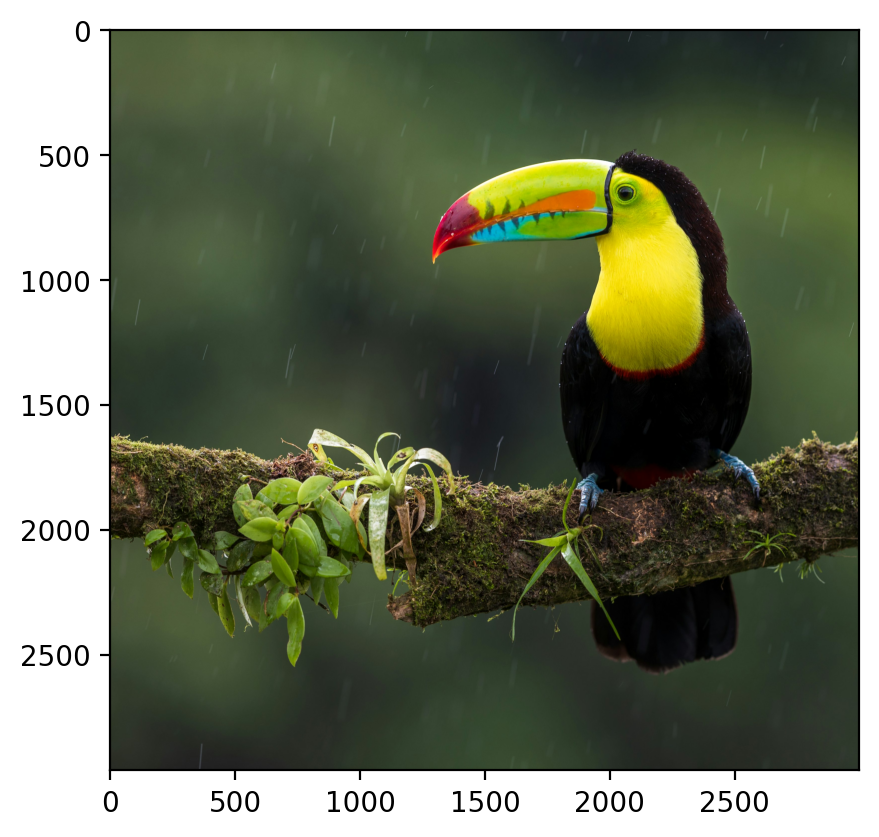

In [52]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [53]:
from sklearn import preprocessing
#Scaling the image tensor
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [54]:
#Apply the fitted scaler to the reshaped image data and reshape back to original dimensions.
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape) 
print(img_scaled.shape)

img_scaled = torch.tensor(img_scaled)

(3, 2961, 3000)


In [55]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.2980, 0.2980, 0.3020,  ..., 0.1608, 0.1608, 0.1608],
         [0.2980, 0.3020, 0.3020,  ..., 0.1608, 0.1608, 0.1608],
         [0.3059, 0.3020, 0.3020,  ..., 0.1608, 0.1608, 0.1608],
         ...,
         [0.1647, 0.1647, 0.1647,  ..., 0.1843, 0.1843, 0.1843],
         [0.1647, 0.1647, 0.1647,  ..., 0.1843, 0.1843, 0.1843],
         [0.1647, 0.1647, 0.1686,  ..., 0.1882, 0.1882, 0.1882]],

        [[0.3608, 0.3608, 0.3647,  ..., 0.2118, 0.2118, 0.2118],
         [0.3608, 0.3647, 0.3647,  ..., 0.2118, 0.2118, 0.2118],
         [0.3686, 0.3647, 0.3647,  ..., 0.2118, 0.2118, 0.2118],
         ...,
         [0.1765, 0.1765, 0.1765,  ..., 0.2157, 0.2157, 0.2157],
         [0.1765, 0.1765, 0.1765,  ..., 0.2157, 0.2157, 0.2157],
         [0.1765, 0.1765, 0.1804,  ..., 0.2196, 0.2196, 0.2196]],

        [[0.2157, 0.2157, 0.2196,  ..., 0.1725, 0.1725, 0.1725],
         [0.2157, 0.2196, 0.2196,  ..., 0.1725, 0.1725, 0.1725],
         [0.2235, 0.2196, 0.2196,  ..., 0.1725, 0.1725, 0.

In [56]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 1850, 300, 300) #cropping the image
crop.shape

torch.Size([3, 300, 300])

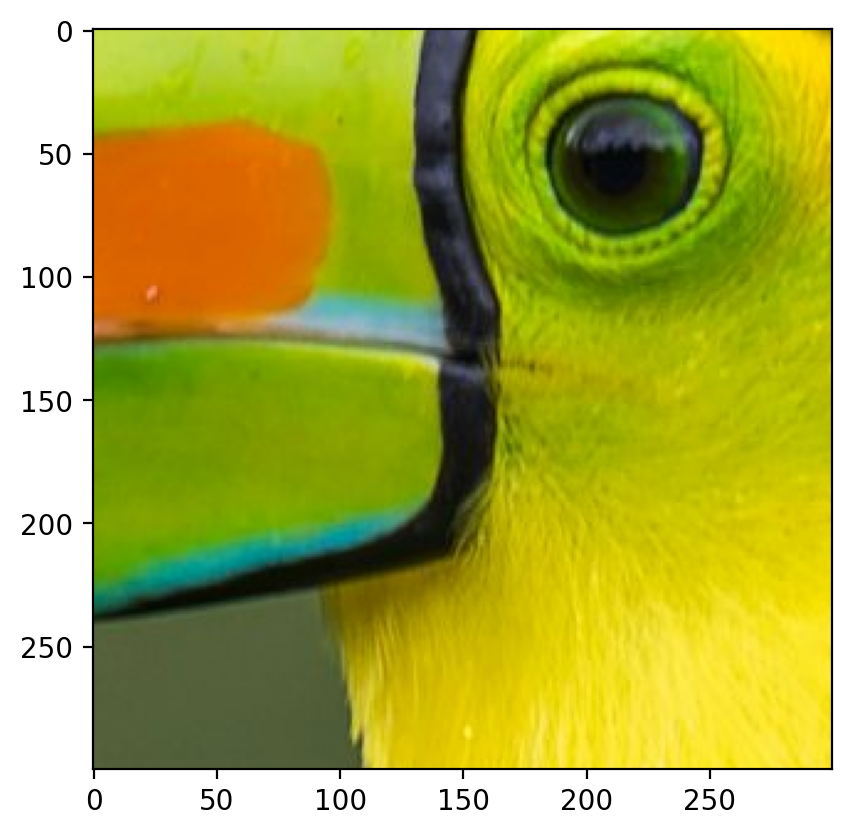

In [57]:
# Rearrange the dimensions of 'crop' from 'c h w' to 'h w c' for proper display,and then converting to a numpy array
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [58]:
crop = crop.to(device)

In [59]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


# Reconstruction using raw (scaled) version

In [60]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [61]:
toucan_X, toucan_Y = create_coordinate_map(crop)

toucan_X.shape, toucan_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [62]:
# MinMaxScaler from -1 to 1 to stabilize training of the neural network
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(toucan_X.cpu())

# Scale the X coordinates
toucan_X_scaled = scaler_X.transform(toucan_X.cpu())

# Move the scaled X coordinates to the GPU
toucan_X_scaled = torch.tensor(toucan_X_scaled).to(device)

# Set to dtype float32
toucan_X_scaled = toucan_X_scaled.float()

In [63]:
#Lineaer Regression using neural networks

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        # Define a linear transformation layer
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        # Apply the linear transformation
        return self.linear(x)

In [64]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [65]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    Train the neural network.

    net: torch.nn.Module - The model to train
    lr: float - Learning rate for the optimizer
    X: torch.Tensor of shape (num_samples, 2) - Input features
    Y: torch.Tensor of shape (num_samples, 3) - Target outputs
    """
    
    criterion = nn.MSELoss()  # Loss function
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # Optimizer

    for epoch in range(epochs):
        optimizer.zero_grad()  # Clears old gradients
        outputs = net(X)  # Forward pass

        loss = criterion(outputs, Y)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item(), outputs  # Return final loss and reconstructed image 


In [66]:
loss_scaled, reconstructed_img_scaled = train(net, 0.01, toucan_X_scaled, toucan_Y, 1000)

Epoch 0 loss: 0.637205
Epoch 100 loss: 0.068675
Epoch 200 loss: 0.036542
Epoch 300 loss: 0.036075
Epoch 400 loss: 0.036074
Epoch 500 loss: 0.036074
Epoch 600 loss: 0.036074
Epoch 700 loss: 0.036074
Epoch 800 loss: 0.036074
Epoch 900 loss: 0.036074


In [67]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient computation to save memory and computation
        outputs = net(X) # Perform forward pass without tracking gradients and get outputs
        outputs = outputs.reshape(height, width, num_channels)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu()) #Show reconstructed image
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0)) # Show original image (permute channels)
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

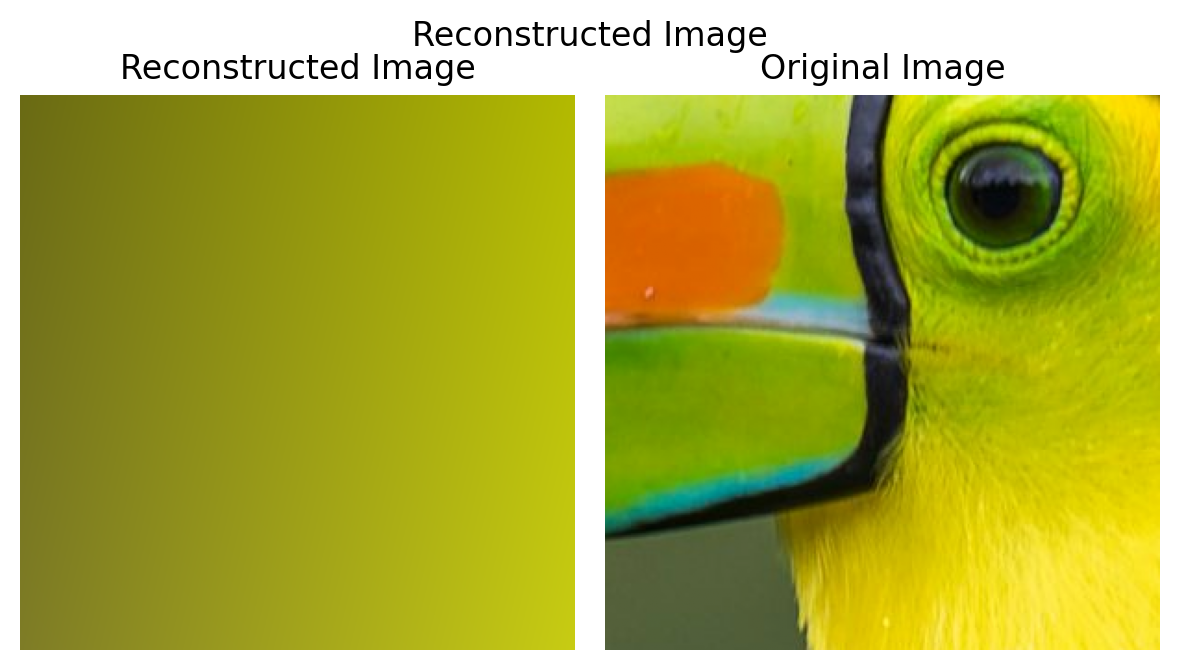

In [68]:
plot_reconstructed_and_original_image(crop, net, toucan_X_scaled, title="Reconstructed Image")

# Reconstruction using polynomial features

In [69]:
# Use polynomial features of degree "d"

def poly_features(X, degree):
    """
    X: torch.Tensor of shape (num_samples, 2) - Input features
    degree: int - Degree of polynomial features

    return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
    """
    X1 = X[:, 0].unsqueeze(1)  # Extract and reshape first feature
    X2 = X[:, 1].unsqueeze(1)  # Extract and reshape second feature
    X = torch.cat([X1, X2], dim=1)  # Combine features

    poly = preprocessing.PolynomialFeatures(degree=degree)  # Initialize polynomial feature transformer
    X = poly.fit_transform(X.cpu())  # Generate polynomial features

    return torch.tensor(X, dtype=torch.float32).to(device)  # Convert to tensor and move to device

In [70]:
toucan_X_scaled_poly = poly_features(toucan_X_scaled, 50)

In [71]:
print("Data type of toucan_X_scaled_poly: ",toucan_X_scaled_poly.dtype) 
print("Data type of toucan_Y: ",toucan_Y.dtype)
print("Shape of toucan_X_scaled_poly: ",toucan_X_scaled_poly.shape)
print("Shape of toucan_Y: ",toucan_Y.shape)

Data type of toucan_X_scaled_poly:  torch.float32
Data type of toucan_Y:  torch.float32
Shape of toucan_X_scaled_poly:  torch.Size([90000, 1326])
Shape of toucan_Y:  torch.Size([90000, 3])


In [72]:
net = LinearModel(toucan_X_scaled_poly.shape[1], 3)
net.to(device)

loss_poly, reconstructed_img_poly = train(net, 0.005, toucan_X_scaled_poly, toucan_Y, 1500)

Epoch 0 loss: 0.275086
Epoch 100 loss: 0.020333
Epoch 200 loss: 0.017411
Epoch 300 loss: 0.016544
Epoch 400 loss: 0.015982
Epoch 500 loss: 0.015567
Epoch 600 loss: 0.015249
Epoch 700 loss: 0.015000
Epoch 800 loss: 0.014800
Epoch 900 loss: 0.014637
Epoch 1000 loss: 0.014498
Epoch 1100 loss: 0.014378
Epoch 1200 loss: 0.014274
Epoch 1300 loss: 0.014176
Epoch 1400 loss: 0.014131


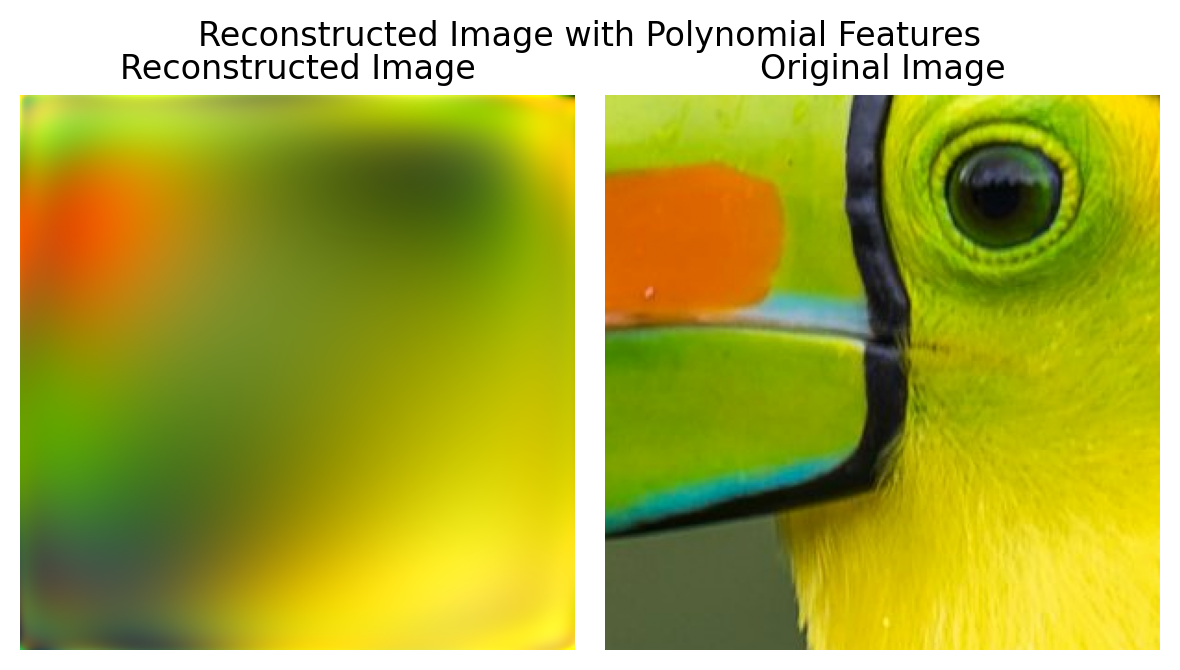

In [73]:
plot_reconstructed_and_original_image(crop, net, toucan_X_scaled_poly, title="Reconstructed Image with Polynomial Features")

# Reconstruction using Random Fourier Features (RFF)

In [28]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


In [29]:
X_rff = create_rff_features(toucan_X_scaled, 37500, 0.008)

In [30]:
X_rff.shape

torch.Size([90000, 37500])

In [31]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

loss_rff, reconstructed_image_rff = train(net, 0.005, X_rff, toucan_Y, 2500)

Epoch 0 loss: 0.284572
Epoch 100 loss: 0.041707
Epoch 200 loss: 0.014589
Epoch 300 loss: 0.010147
Epoch 400 loss: 0.007554
Epoch 500 loss: 0.005687
Epoch 600 loss: 0.004289
Epoch 700 loss: 0.003231
Epoch 800 loss: 0.002428
Epoch 900 loss: 0.001821
Epoch 1000 loss: 0.001363
Epoch 1100 loss: 0.001020
Epoch 1200 loss: 0.000764
Epoch 1300 loss: 0.000575
Epoch 1400 loss: 0.000435
Epoch 1500 loss: 0.000334
Epoch 1600 loss: 0.000261
Epoch 1700 loss: 0.000209
Epoch 1800 loss: 0.000172
Epoch 1900 loss: 0.000146
Epoch 2000 loss: 0.000128
Epoch 2100 loss: 0.000115
Epoch 2200 loss: 0.000107
Epoch 2300 loss: 0.000101
Epoch 2400 loss: 0.000097


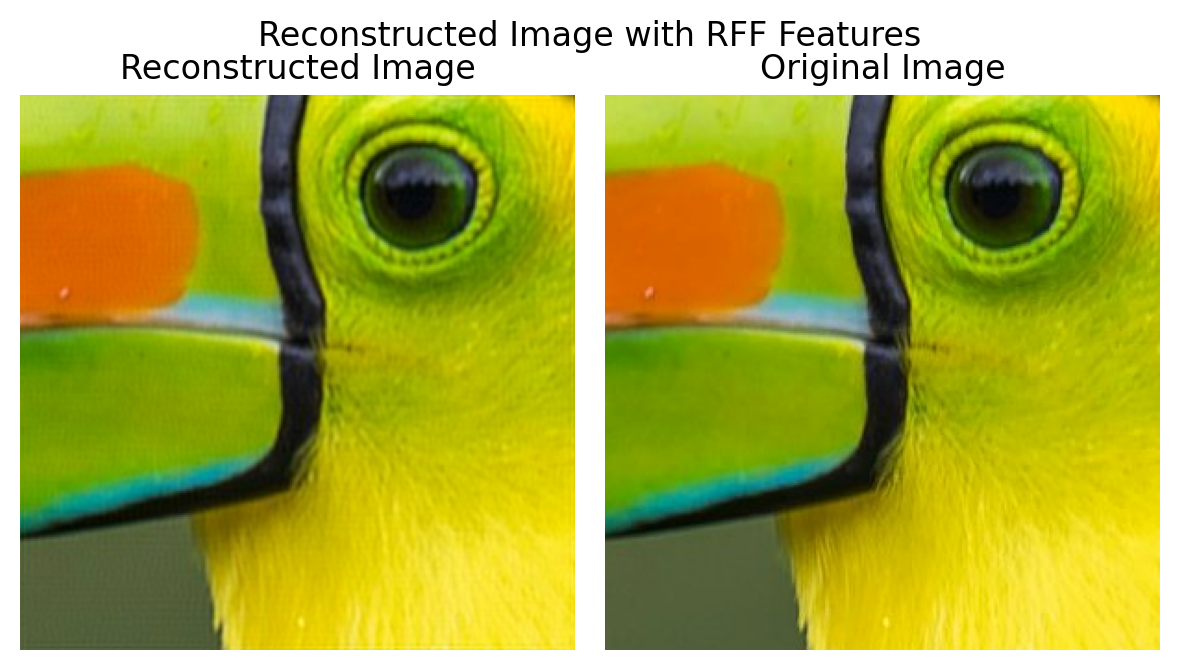

In [32]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [45]:
import skimage.metrics as metrics

def calculate_rmse_and_psnr(original_img, reconstructed_img):
    """
    original_img: torch.Tensor - Original image tensor of shape (num_channels, height, width)
    reconstructed_img: torch.Tensor - Reconstructed image tensor of shape (num_channels, height, width)
    
    return: tuple - (RMSE, PSNR)
    """
    # Ensure images are on CPU and convert to NumPy arrays
    original_img = original_img.detach().cpu().numpy()  # Detach before converting to NumPy
    reconstructed_img = reconstructed_img.detach().cpu().numpy()  # Detach before converting to NumPy
    
    # Compute RMSE
    mse = np.mean((original_img - reconstructed_img) ** 2)
    rmse = np.sqrt(mse)
    
    # Compute PSNR
    psnr = metrics.peak_signal_noise_ratio(original_img, reconstructed_img, data_range=1.0)
    
    return rmse, psnr

rmse, psnr = calculate_rmse_and_psnr(toucan_Y, reconstructed_image_rff)
print(f"RMSE: {rmse:.4f}")
print(f"PSNR: {psnr:.2f} dB")


RMSE: 0.0097
PSNR: 40.27 dB


RMSE: 0.0097 and PSNR: 40.27 dB indicate very high-quality reconstruction. The model has done an excellent job in replicating the original image with minimal errors and very high fidelity. These values suggest a successful and accurate image reconstruction.This is possible because of using Random Fourier Features (RFF)